In [1]:
import pickle
import numpy as np
import os

# import tensorflow as tf
# import tensorflow.keras as keras
# gpu setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  

import warnings
warnings.filterwarnings("ignore")

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

In [2]:
#to_load
with open ('/home/Playground/DEC-keras/temp.pkl', 'rb') as pickle_file:
     df_pickle = pickle.load(pickle_file)

In [3]:
df_pickle.shape

(3186, 300)

In [5]:
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling

In [22]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

        Junyuan Xie, Ross Girshick, and Ali Farhadi. Unsupervised deep embedding for clustering analysis. ICML 2016.

Usage:
    use `python DEC.py -h` for help.

Author:
    Xifeng Guo. 2017.1.30
"""

from time import time
import numpy as np

from sklearn.cluster import KMeans
import metrics


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if int(epochs/10) != 0 and epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: %ds' % round(time() - t0))
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = int(x.shape[0] / batch_size) * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred



In [23]:
df_pickle.shape

(3186, 300)

In [49]:
# prepare the DEC model
# dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, init=init)


# if args.ae_weights is None:
#     dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
#                     epochs=pretrain_epochs, batch_size=args.batch_size,
#                     save_dir=args.save_dir)
# else:
#     dec.autoencoder.load_weights(args.ae_weights)
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                               distribution='uniform')

dec = DEC(dims=[df_pickle.shape[-1], 500, 500, 2000, 10], n_clusters=40, init=init)
dec.model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               150500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 40)                400       
Total params: 1,423,410
Trainable params: 1,423,410
Non-trainable params: 0
_________________________________________________

In [26]:
# # print(args)
# import os
# if not os.path.exists("/results"):
#     os.makedirs("results")


In [50]:
t0 = time()
dec.compile(optimizer='Adam', loss='kld')
y_pred = dec.fit(x=df_pickle)
# print('acc:', metrics.acc(df_pickle, df_pickle))
# print('clustering time: ', (time() - t0))

Update interval 140
Save interval 60
Initializing cluster centers with k-means.
saving model to: ./results/temp/DEC_model_0.h5
saving model to: ./results/temp/DEC_model_60.h5
saving model to: ./results/temp/DEC_model_120.h5
saving model to: ./results/temp/DEC_model_180.h5
saving model to: ./results/temp/DEC_model_240.h5
saving model to: ./results/temp/DEC_model_300.h5
saving model to: ./results/temp/DEC_model_360.h5
saving model to: ./results/temp/DEC_model_420.h5
saving model to: ./results/temp/DEC_model_480.h5
saving model to: ./results/temp/DEC_model_540.h5
saving model to: ./results/temp/DEC_model_600.h5
saving model to: ./results/temp/DEC_model_660.h5
saving model to: ./results/temp/DEC_model_720.h5
saving model to: ./results/temp/DEC_model_780.h5
saving model to: ./results/temp/DEC_model_840.h5
saving model to: ./results/temp/DEC_model_900.h5
saving model to: ./results/temp/DEC_model_960.h5
saving model to: ./results/temp/DEC_model_1020.h5
saving model to: ./results/temp/DEC_mode

In [29]:
y_pred.shape

(3186,)

In [33]:
np.where(y_pred == 0)[0]

array([  20,   53,   63,   66,   68,   70,   72,  157,  171,  185,  225,
        229,  233,  241,  260,  378,  390,  392,  396,  440,  444,  450,
        499,  532,  538,  544,  548,  550,  552,  558,  566,  568,  570,
        572,  621,  660,  673,  702,  705,  707,  736,  802,  831,  837,
        845,  940,  946,  952,  954,  978,  981,  983,  985,  988,  997,
       1001, 1003, 1005, 1011, 1013, 1015, 1017, 1020, 1024, 1035, 1043,
       1045, 1056, 1061, 1064, 1079, 1107, 1165, 1221, 1228, 1243, 1277,
       1288, 1306, 1346, 1363, 1365, 1369, 1375, 1503, 1520, 1537, 1555,
       1569, 1571, 1578, 1586, 1590, 1695, 1697, 1699, 1701, 1703, 1717,
       1720, 1722, 1725, 1730, 1734, 1738, 1741, 1774, 1812, 1814, 1818,
       1841, 1858, 1882, 1884, 1895, 1897, 1904, 1908, 1973, 1992, 1994,
       1999, 2004, 2022, 2024, 2041, 2050, 2075, 2085, 2089, 2114, 2127,
       2137, 2159, 2163, 2180, 2186, 2190, 2195, 2214, 2223, 2226, 2228,
       2230, 2232, 2234, 2236, 2238, 2240, 2242, 22

In [31]:
df_pickle[0]

array([1.29, 1.29, 1.29, 1.29, 0.3 , 0.3 , 0.7 , 0.7 , 1.13, 1.13, 1.13,
       2.9 , 2.9 , 2.9 , 2.9 , 1.67, 1.67, 1.4 , 1.4 , 1.4 , 1.21, 1.21,
       1.21, 1.2 , 1.2 , 1.63, 1.63, 1.63, 2.49, 2.49, 2.49, 3.08, 3.08,
       3.85, 3.85, 3.85, 3.85, 3.81, 3.81, 3.81, 3.7 , 3.7 , 3.43, 3.43,
       3.47, 3.47, 3.47, 3.47, 3.41, 3.41, 3.41, 3.36, 3.36, 3.56, 3.56,
       3.56, 3.53, 3.53, 3.53, 3.46, 3.46, 3.46, 3.32, 3.32, 3.34, 3.34,
       3.34, 3.53, 3.53, 3.62, 3.62, 3.62, 3.8 , 3.8 , 3.8 , 4.54, 4.54,
       4.54, 5.84, 5.84, 5.84, 7.08, 7.08, 7.08, 6.64, 6.64, 7.38, 7.38,
       7.38, 8.48, 8.48, 8.48, 7.26, 7.26, 7.26, 7.17, 7.17, 7.17, 5.  ,
       5.  , 5.  , 3.26, 3.26, 3.26, 3.  , 3.  , 3.85, 3.85, 3.85, 3.52,
       3.52, 3.52, 0.69, 0.69, 1.34, 1.34, 1.34, 0.14, 0.14, 0.14, 0.13,
       0.13, 0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [40]:
np.unique(y_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

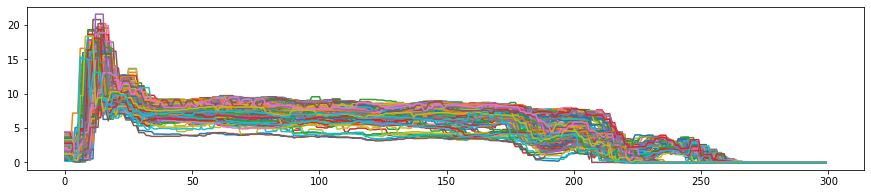

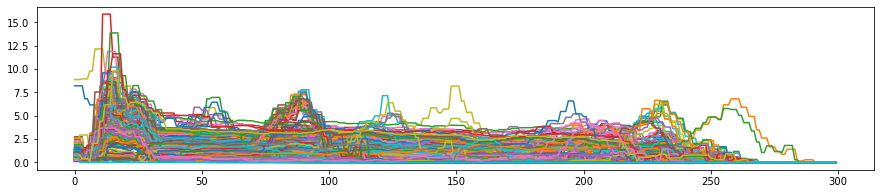

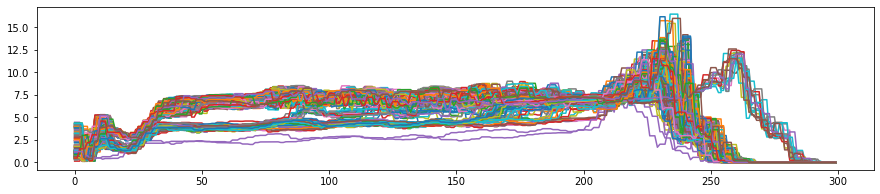

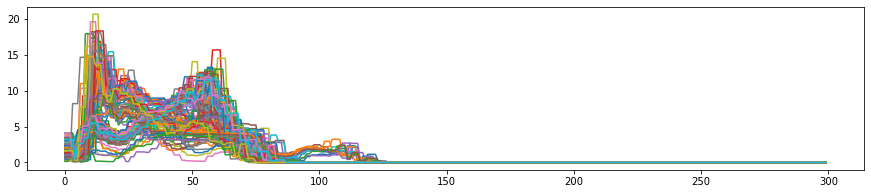

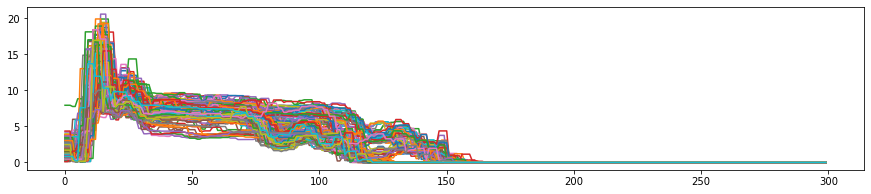

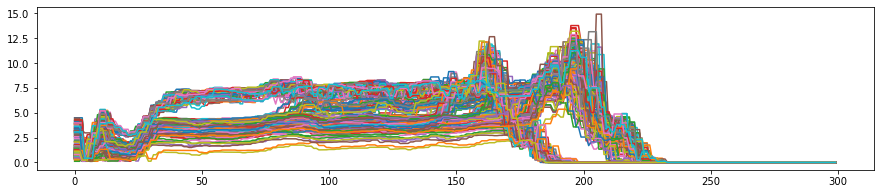

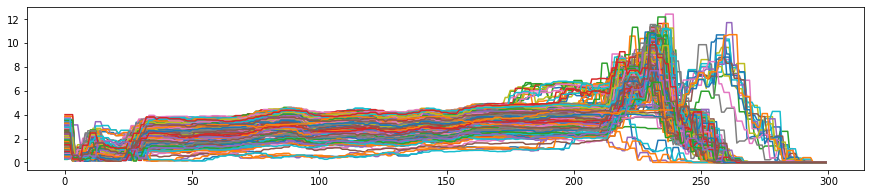

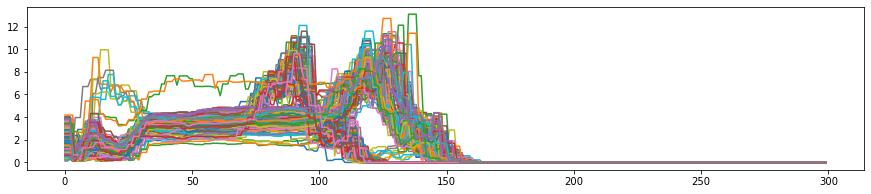

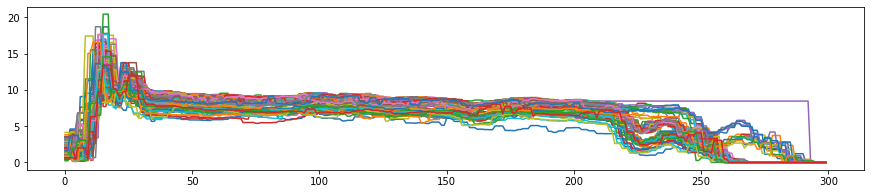

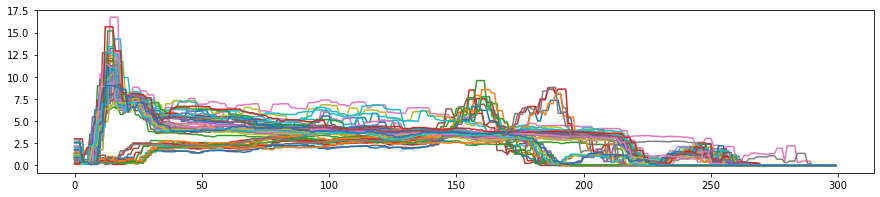

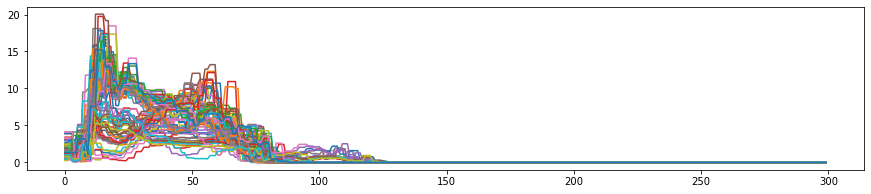

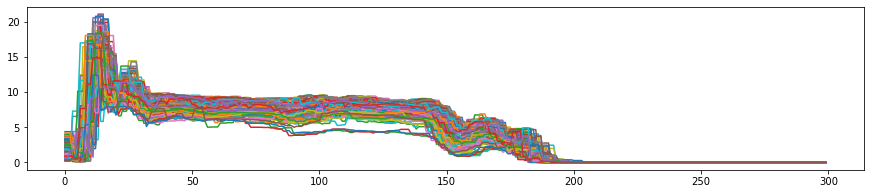

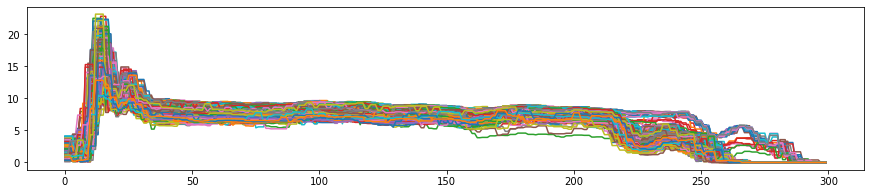

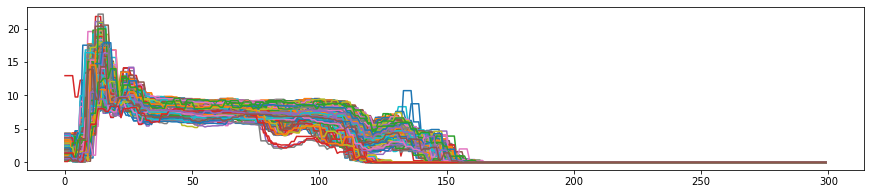

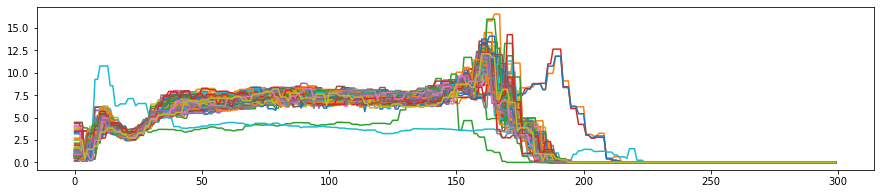

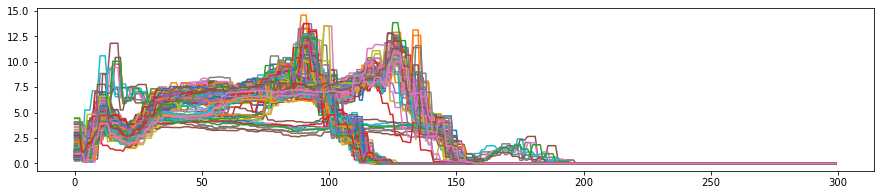

In [48]:
import matplotlib.pyplot as plt


# label_list = np.where(y_pred == 10)[0]
# fig, ax = plt.subplots(figsize=(15, 3))

for j in np.unique(y_pred):
    fig, ax = plt.subplots(figsize=(15, 3))
    label_list = np.where(y_pred == j)[0]
    for i in list(label_list):
        ax.plot(df_pickle[i])
        # ax.set_title(f'Cluster {i}')
    plt.show()

In [51]:
 
def call(self, inputs, **kwargs):
    """ student t-distribution, as same as used in t-SNE algorithm.
                q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
    Arguments:
        inputs: the variable containing data, shape=(n_samples, n_features)
    Return:
        q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
    """
    q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
    q **= (self.alpha + 1.0) / 2.0
    q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
    return q
# add documentation


In [ ]:
# # config_tf = ConfigProto()
# # config_tf.gpu_options.allow_growth = True
# # with tf.compat.v1.Session(config=config_tf) as sess: #with strategy.scope():#

#     # setting the hyper parameters
#     import argparse

#     parser = argparse.ArgumentParser(description='train',
#                                      formatter_class=argparse.ArgumentDefaultsHelpFormatter)
#     parser.add_argument('--dataset', default='mnist',
#                         choices=['mnist', 'fmnist', 'usps', 'reuters10k', 'stl'])
#     parser.add_argument('--batch_size', default=256, type=int)
#     parser.add_argument('--maxiter', default=2e4, type=int)
#     parser.add_argument('--pretrain_epochs', default=None, type=int)
#     parser.add_argument('--update_interval', default=None, type=int)
#     parser.add_argument('--tol', default=0.001, type=float)
#     parser.add_argument('--ae_weights', default=None)
#     parser.add_argument('--save_dir', default='results')
#     args = parser.parse_args()
#     print(args)
#     import os
#     if not os.path.exists(args.save_dir):
#         os.makedirs(args.save_dir)

#     # load dataset
#     from datasets import load_data
#     x, y = load_data(args.dataset)
#     n_clusters = len(np.unique(y))

#     init = 'glorot_uniform'
#     pretrain_optimizer = 'adam'
#     # setting parameters
#     if args.dataset == 'mnist' or args.dataset == 'fmnist':
#         update_interval = 140
#         pretrain_epochs = 300
#         init = VarianceScaling(scale=1. / 3., mode='fan_in',
#                                distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#         pretrain_optimizer = SGD(lr=1, momentum=0.9)
#     elif args.dataset == 'reuters10k':
#         update_interval = 30
#         pretrain_epochs = 50
#         init = VarianceScaling(scale=1. / 3., mode='fan_in',
#                                distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#         pretrain_optimizer = SGD(lr=1, momentum=0.9)
#     elif args.dataset == 'usps':
#         update_interval = 30
#         pretrain_epochs = 50
#     elif args.dataset == 'stl':
#         update_interval = 30
#         pretrain_epochs = 10

#     if args.update_interval is not None:
#         update_interval = args.update_interval
#     if args.pretrain_epochs is not None:
#         pretrain_epochs = args.pretrain_epochs

    # prepare the DEC model
    dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, init=init)

    if args.ae_weights is None:
        dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
                     epochs=pretrain_epochs, batch_size=args.batch_size,
                     save_dir=args.save_dir)
    else:
        dec.autoencoder.load_weights(args.ae_weights)

    dec.model.summary()
    t0 = time()
    dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')
    y_pred = dec.fit(x, y=y, tol=args.tol, maxiter=args.maxiter, batch_size=args.batch_size,
                     update_interval=update_interval, save_dir=args.save_dir)
    print('acc:', metrics.acc(y, y_pred))
    print('clustering time: ', (time() - t0))